# Regla de aprendizaje de Rosenblatt

El primer esfuerzo para que el perceptrón aprendiera a partir de datos fue la regla de aprendizaje presentada por Frank Rosenblatt. En este notebook aplicaremos dicha regla para observar el comportamiento sobre un conjuinto de datos sintético.

@juan1rving

In [35]:
import nni.functions as nf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

colors = ['red', 'blue']
cmap = ListedColormap(colors[:len(np.unique(y))])

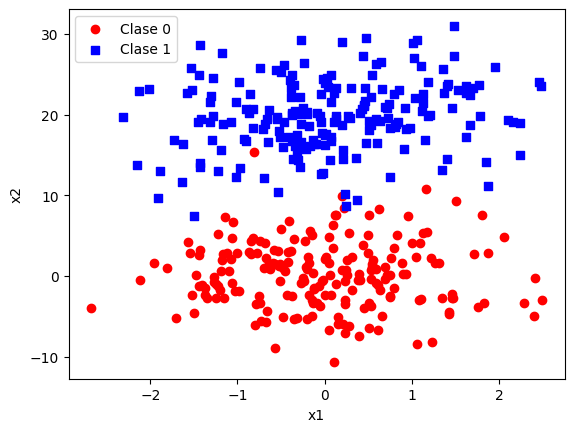

In [36]:
# Generar datos sintéticos
X, y = nf.datosSinteticos()

# Visualizar los datos
fig = plt.figure()
ax = fig.subplots()
ax.scatter(X.loc[y==0, 'x1'], X.loc[y==0, 'x2'], color='red', marker='o', label='Clase 0')
ax.scatter(X.loc[y==1, 'x1'], X.loc[y==1, 'x2'], color='blue', marker='s', label='Clase 1')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend(loc='upper left')
plt.show()

## Perceptrón

A diferencia del ejercicio previo. En esta ocasión implementaremos el perceptrón como una clase.

In [37]:
class Perceptron:
    def __init__(self, n_entradas, f_activacion):
        self.W = np.zeros((n_entradas,))
        self.b = 0.0
        self._f_activacion = f_activacion

    def inferencia(self, X):
        h = np.dot(X, self.W) + self.b
        return self._f_activacion(h)
    
def escalon(x):
    return np.where(x >= 0, 1, 0)

## Inicialización

El primer paso consite en inicializar los pesos. 

Para inicializar los pesos con una distribución normal, podemos utilizar la función `numpy.random.normal`. Esta función permite especificar la media (`loc`), la desviación estándar (`scale`) y el número de valores a generar (`size`). Por ejemplo, `np.random.normal(loc=0, scale=1, size=(2,))` genera dos valores aleatorios con media 0 y desviación estándar 1. Esta inicialización es útil para romper la simetría y facilitar el aprendizaje del perceptrón.

In [38]:
# Crear una instancia del perceptrón
clasificador = Perceptron(n_entradas=2, f_activacion=escalon)
print("Pesos iniciales:", clasificador.W)
print("Bias inicial:", clasificador.b)

Pesos iniciales: [0. 0.]
Bias inicial: 0.0


In [39]:
# Inicialización de parámetros (1 punto)
clasificador.W = np.random.normal(loc=0, scale=1, size=(2,))
clasificador.b = np.random.normal(loc=0, scale=1)
print("Pesos después de la inicialización:", clasificador.W)
print("Bias después de la inicialización:", clasificador.b) 

Pesos después de la inicialización: [0.73329819 0.32388314]
Bias después de la inicialización: -0.6461962031796615


### Función de pérdida

La función de pérdida nos indica que tanto nos estamos equivocando en el conjunto de datos completo.

En este notebook usaremos la suma de los errores absolutos
$$
\mathcal{L} = SAE = \sum_\mu | y^\mu - \hat{y}^\mu 
$$


In [42]:
# implementa la función de pérdida (1 punto)
def perdidaSAE(y_true, y_pred):
    # Suma de errores absolutos
    return np.sum(np.abs(y_true - y_pred))

y_pred = clasificador.inferencia(X)
print("Pérdida inicial (SAE):", perdidaSAE(y, y_pred))

Pérdida inicial (SAE): 62


A continuación visualizaremos el rendimiento del clasificador de forma gráfica

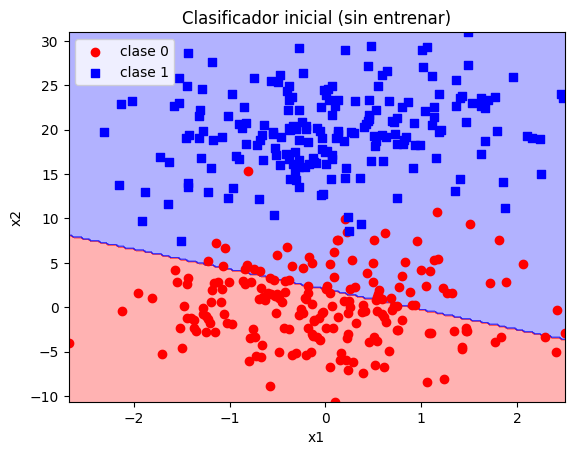

In [43]:
x1, x2 = np.meshgrid(
np.linspace(X.iloc[:,0].min(), X.iloc[:,0].max(), num=200),
    np.linspace(X.iloc[:,1].min(), X.iloc[:,1].max(), num=200)
)
grid = np.vstack([x1.ravel(), x2.ravel()]).T
y_pred = np.reshape(clasificador.inferencia(grid), x1.shape)

fig = plt.figure()
ax = fig.subplots()
display = DecisionBoundaryDisplay(xx0=x1, xx1=x2, response=y_pred)
display.plot(ax=ax, plot_method='contourf', cmap=cmap, alpha=0.3)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.scatter(X.loc[y==0, 'x1'], X.loc[y==0, 'x2'], color='red', marker='o', label='clase 0')
ax.scatter(X.loc[y==1, 'x1'], X.loc[y==1, 'x2'], color='blue', marker='s', label='clase 1')
ax.set_title('Clasificador inicial (sin entrenar)')
ax.legend(loc='upper left')
plt.show()

## Regla de aprendizaje

Primero, recordemos que la regla de aprendizase se basa en que cada error no guia hacia donde mover los pesos. Es decir usamos el error residual:

$$
e^\mu = y^\mu - \hat{y}^\mu
$$

Una vez definido el error residual observemos que la regla de aprendizaje se calcula como

$$
W^{t+1} = W^{t} + \eta (y - \hat{y}) X
$$

Y se repite el cálculo tantas veces como deseemos.


In [45]:
## Implementa la regla de aprendizaje (2 puntos)
class ReglaDeAprendizaje:
    def __init__(self, tasa_aprendizaje=0.1):
        self.tasa_aprendizaje = tasa_aprendizaje

    def actualizar(self, perceptron, X, y):
        for xi, target in zip(X.values, y.values):
            output = perceptron.inferencia(xi)
            error = target - output
            perceptron.W += self.tasa_aprendizaje * error * xi
            perceptron.b += self.tasa_aprendizaje * error

In [48]:
# Configuración del entrenamiento
tasa_aprendizaje = 0.1
n_epocas = 3 #Configura el número de épocas

Época 1: Pérdida (SAE): 78
Época 2: Pérdida (SAE): 55
Época 3: Pérdida (SAE): 71


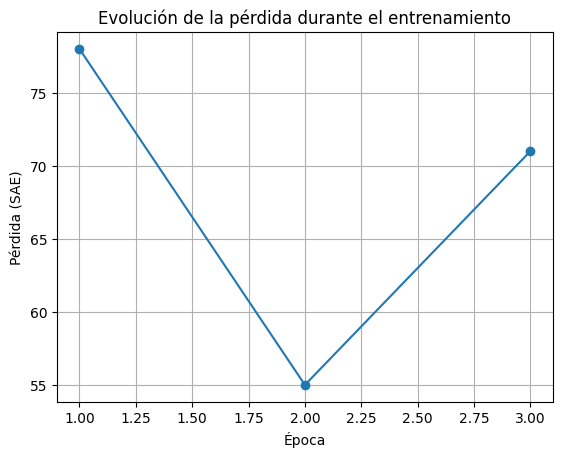

In [49]:
optimizador = ReglaDeAprendizaje(tasa_aprendizaje=tasa_aprendizaje)

historial_perdida = []

for epoca in range(n_epocas):
    y_pred = clasificador.inferencia(X)
    perdida = perdidaSAE(y, y_pred)
    print(f"Época {epoca+1}: Pérdida (SAE): {perdida}")
    historial_perdida.append(perdida)
    optimizador.actualizar(clasificador, X, y)

# Visualizar la pérdida a lo largo de las épocas
plt.plot(range(1, n_epocas + 1), historial_perdida, marker='o')
plt.xlabel('Época')
plt.ylabel('Pérdida (SAE)')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.grid()
plt.show()

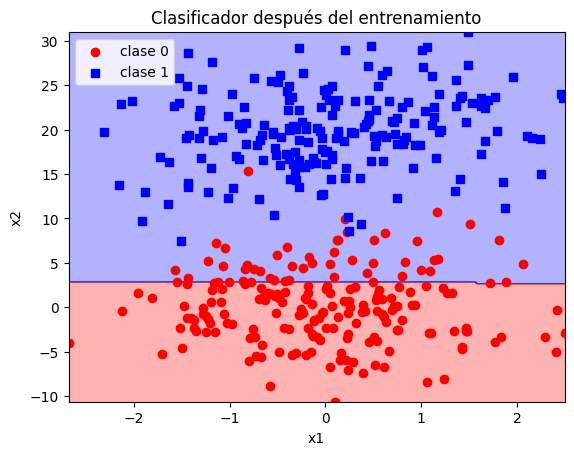

In [50]:
x1, x2 = np.meshgrid(
np.linspace(X.iloc[:,0].min(), X.iloc[:,0].max(), num=200),
    np.linspace(X.iloc[:,1].min(), X.iloc[:,1].max(), num=200)
)
grid = np.vstack([x1.ravel(), x2.ravel()]).T
y_pred = np.reshape(clasificador.inferencia(grid), x1.shape)

fig = plt.figure()
ax = fig.subplots()
display = DecisionBoundaryDisplay(xx0=x1, xx1=x2, response=y_pred)
display.plot(ax=ax, plot_method='contourf', cmap=cmap, alpha=0.3)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.scatter(X.loc[y==0, 'x1'], X.loc[y==0, 'x2'], color='red', marker='o', label='clase 0')
ax.scatter(X.loc[y==1, 'x1'], X.loc[y==1, 'x2'], color='blue', marker='s', label='clase 1')
ax.set_title('Clasificador después del entrenamiento')
ax.legend(loc='upper left')
plt.show()